# [**Mise en cache des plus proches voisins**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_6_neighbors/plot_caching_nearest_neighbors.ipynb)<br/>([_Caching nearest neighbors_](https://scikit-learn.org/stable/auto_examples/neighbors/plot_caching_nearest_neighbors.html))

Cet exemple montre comment pré-calculer les $k$ plus proches voisins avant de les utiliser dans [**`KNeighborsTransformer`**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsTransformer.html#sklearn.neighbors.KNeighborsTransformer). [**`KNeighborsTransformer`**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsTransformer.html#sklearn.neighbors.KNeighborsTransformer) peut calculer les plus proches voisins en interne, mais leur pré-calcul peut présenter plusieurs avantages, tels qu'un meilleur contrôle des paramètres, une mise en cache pour une utilisation multiple, ou des implémentations personnalisées.

Ici, nous utilisons la propriété de mise en cache des pipelines pour stocker en cache le graphe des plus proches voisins entre plusieurs ajustements de [**`KNeighborsTransformer`**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsTransformer.html#sklearn.neighbors.KNeighborsTransformer). Le premier appel est lent car il calcule le graphe des voisins, tandis que les appels ultérieurs sont plus rapides car ils n'ont pas besoin de recalculer le graphe. Ici, les durées sont courtes car l'ensemble de données est petit, mais le gain peut être plus important lorsque l'ensemble de données devient plus grand, ou lorsque la grille de paramètres à rechercher est grande.

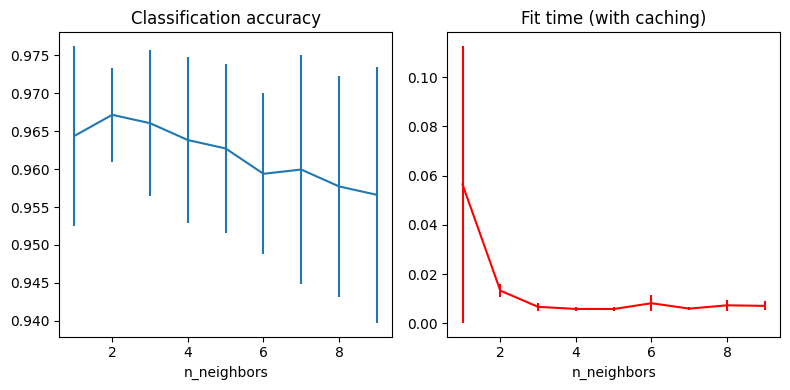

In [1]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

X, y = load_digits(return_X_y=True)
n_neighbors_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid)
    grid_model.fit(X, y)

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()